In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler

Загрузим данные

In [2]:
data = pd.read_csv("SAMPL.csv")
data.head()

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


Прочитаем SMILES

,smiles,Molecule
0,CN(C)C(=O)c1ccc(cc1)OC,

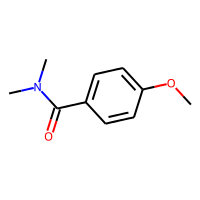

In [3]:
PandasTools.AddMoleculeColumnToFrame(data, "smiles", "Molecule")
data[["smiles", "Molecule"]].head(1)

In [4]:
data[["Molecule", "expt"]].iloc[0]

Molecule    <img data-content="rdkit/molecule" src="data:i...
expt                                                   -11.01
Name: 0, dtype: object

Загрузим метод для перевода молекулы из rdkit в данные для pytorch-geometric.

In [5]:
import torch
from torch_geometric.data import Data
from rdkit.Chem import Mol
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from scipy.sparse import coo_matrix

def rdkit_to_pyg(mol: Mol, expt: float) -> Data:
    adj_mat = torch.tensor(GetAdjacencyMatrix(mol))
    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]

    # Connectivity list and edge features
    edges = []
    edge_types = []
    for bond in mol.GetBonds():
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        bond_type = int(bond.GetBondType())
        edges.extend([[begin_idx, end_idx], [end_idx, begin_idx]])
        edge_types.extend([[bond_type], [bond_type]])

    edge_index = torch.LongTensor(edges).t().contiguous()
    edge_features = torch.LongTensor(edge_types)
    node_features = torch.LongTensor(atoms).reshape(-1, 1)
    target = torch.FloatTensor([[expt]])

    return Data(x = node_features, edge_index=edge_index, edge_attr=edge_features, target=target)

In [6]:
rdkit_to_pyg(*data[["Molecule", "expt"]].iloc[0])


Data(x=[13, 1], edge_index=[2, 26], edge_attr=[26, 1], target=[1, 1])

In [7]:
from torch.utils.data import DataLoader, Dataset

class SmilesDataset(Dataset):
    """SMILES dataset """
    def __init__(self, data: pd.DataFrame) -> None:
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        mol, expt = data[["Molecule", "expt"]].iloc[index]
        return rdkit_to_pyg(mol, expt)

In [8]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.node_emb(x)

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [9]:
[m for data[["Molecule", "expt"]]]

SyntaxError: invalid syntax (3829085726.py, line 1)

In [ ]:
from torch_geometric.loader import DataLoader
device = "cuda"
loader = DataLoader([rdkit_to_pyg(mol, expt) for mol, expt in data[["Molecule", "expt"]].values], batch_size=32)
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(10):
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out, batch.y)
        loss.backward()
        print(loss.item())
        print(batch.num_nodes)
        optimizer.step()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.